**TBATS**: periodo di 2 anni più tre mesi 2022, osservazioni trimestrali, due stagionalità: settimanale e annuale

**T**rigonometric seasonality, **B**ox-Cox transformation, **A**RMA errors, **T**rend and **S**easonal components.

![tbats](https://miro.medium.com/max/1050/1*yfruZnSYsNt1X1uyag46eQ.png)

Each seasonality is modeled by a trigonometric representation based on Fourier series. One major advantage of this approach is that it requires only 2 seed states regardless of the length of period. Another advantage is the ability to model seasonal effects of non-integer lengths. For example, given a series of daily observations, one can model leap years with a season of length 365.25.

**BATS** differs from TBATS only in the way it models seasonal effects. In BATS we have a more traditional approach where each seasonality is modeled by:

![bats](https://miro.medium.com/max/1050/1*D8KY2jQRmVRLHY5f4RNqKA.png)

This implies that BATS can only model integer period lengths. Approach taken in BATS requires m_i seed states for season i, if this season is long the model may become intractable.

How Does TBATS Choose The Final Model

Under the hood TBATS will consider various alternatives and fit quite a few models. It will consider models:
- with Box-Cox transformation and without it.
- with and without Trend
- with and without Trend Damping
- with and without ARMA(p,q) process used to model residuals
- non-seasonal model
- various amounts of harmonics used to model seasonal effects

The final model will be chosen using Akaike information criterion (AIC).

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tbats import BATS, TBATS

In [3]:
df = pd.read_csv('../data/casual_trimestrale.csv')
df.head()

,Unnamed: 0,year,revenue
0,0,2014-03-31,618890.53
1,1,2014-06-30,886224.60
2,2,2014-09-30,1133497.77
3,3,2014-12-31,877819.29
4,4,2015-03-31,1661470.04


In [4]:
# df = df[(df['settore'] == 'Pesca')] # df solo pesca
df = df.rename(columns={"year": "data", "revenue": "totale"})
df['data'] = pd.to_datetime(df['data'])

In [5]:
df.dtypes

Unnamed: 0             int64
data          datetime64[ns]
totale               float64
dtype: object

In [6]:
df.head()

,Unnamed: 0,data,totale
0,0,2014-03-31,618890.53
1,1,2014-06-30,886224.60
2,2,2014-09-30,1133497.77
3,3,2014-12-31,877819.29
4,4,2015-03-31,1661470.04


In [7]:
mask = (df['data'] < '2022-01-01')

In [8]:
df = df.loc[mask]

In [9]:
df

,Unnamed: 0,data,totale
0,0,2014-03-31,618890.53
1,1,2014-06-30,886224.60
2,2,2014-09-30,1133497.77
3,3,2014-12-31,877819.29
4,4,2015-03-31,1661470.04
5,5,2015-06-30,1461337.48
6,6,2015-09-30,1415946.31
7,7,2015-12-31,1277021.07
8,8,2016-03-31,1307658.25
9,9,2016-06-30,1307577.72


In [10]:
df = df.set_index('data')
df.head()

,Unnamed: 0,totale
data,,
2014-03-31,0,618890.53
2014-06-30,1,886224.60
2014-09-30,2,1133497.77
2014-12-31,3,877819.29
2015-03-31,4,1661470.04


In [11]:
df = df[['totale']]
df.head()

,totale
data,
2014-03-31,618890.53
2014-06-30,886224.60
2014-09-30,1133497.77
2014-12-31,877819.29
2015-03-31,1661470.04


In [12]:
y = df['totale']

In [13]:
len(y)

32

In [14]:
len(y) / 100 * 20

6.4

In [15]:
steps = 6

y_to_train = y.iloc[:(len(y)-steps)]
y_to_test = y.iloc[(len(y)-steps):] # last year for testing

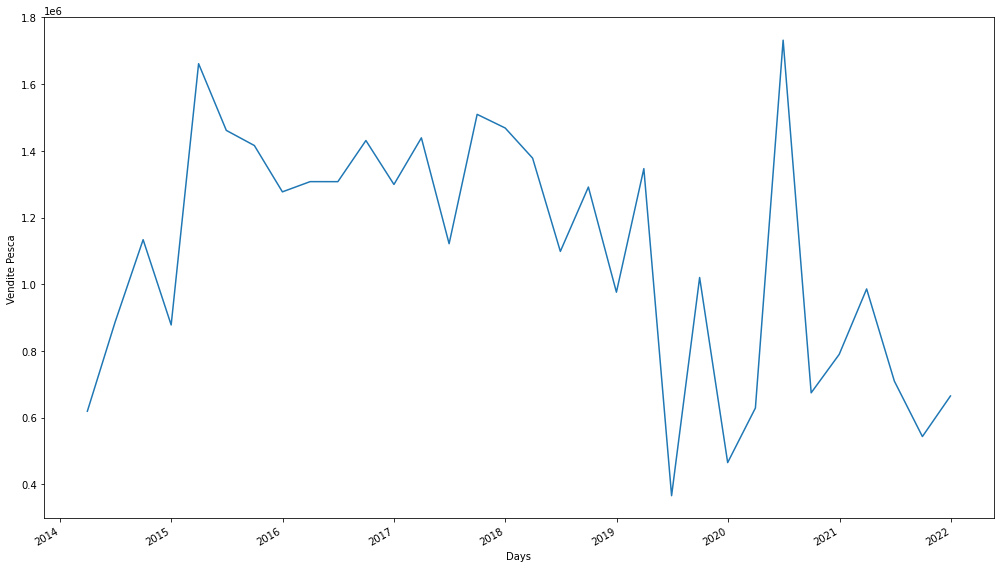

In [16]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(df['totale'])
ax.set_xlabel('Days')
ax.set_ylabel('Vendite Pesca')

fig.autofmt_xdate()

plt.tight_layout()
plt.show()

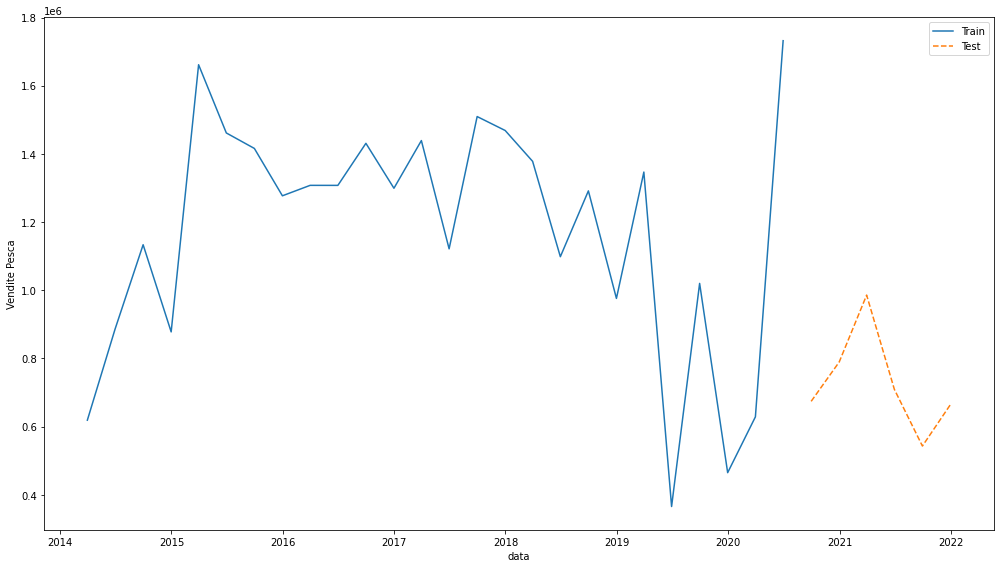

In [17]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_to_train, ls='-', label='Train')
ax.plot(y_to_test, ls='--', label='Test')
ax.set_xlabel('data')
ax.set_ylabel('Vendite Pesca')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

Da questa figura dovremmo individuare pattern di stagionalità. (Ad esempio settimanale, mensile, annuale, ecc.)

Before we implement our more complex BATS and TBATS models, it’s always a good idea to have a baseline model. That way, we can determine if our more complex forecasting methods are actually performant.

In [18]:
y_pred_baseline = y_to_train[-steps:].values

In [19]:
# Fit the model
estimator = TBATS()
model = estimator.fit(y_to_train)

# Forecast 365 days ahead
y_forecast = model.forecast(steps)

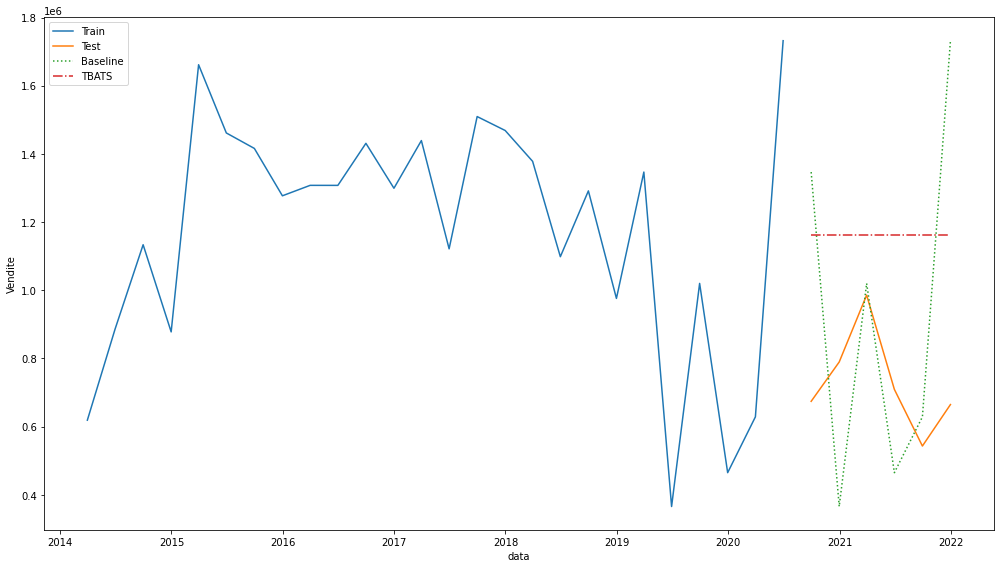

In [20]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(y_to_train, ls='-', label='Train')
ax.plot(y_to_test, ls='-', label='Test')
ax.plot(y_to_test.index, y_pred_baseline, ls=':', label='Baseline')
ax.plot(y_to_test.index, y_forecast, ls='-.', label='TBATS')

ax.set_xlabel('data')
ax.set_ylabel('Vendite')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

MAPE

In [21]:
print('Did the model fit?', model.is_fitted)  # Model may fail to fit in edge-case situations
print('AIC', model.aic)  # may be np.inf

Did the model fit? True
AIC 752.2144455527163


In [22]:
# Short model summary
print('\n\nSUMMARY FUNCTION\n\n')
print(model.summary())



SUMMARY FUNCTION


Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: []
Seasonal harmonics []
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): -0.010000
Seasonal Parameters (Gamma): []
AR coefficients []
MA coefficients []
Seed vector [1165260.10967186]

AIC 752.214446


In [23]:
print('\n\nIN SAMPLE PREDICTIONS\n\n')
print('Original time series (5 first values)', model.y[:5])
print('Predictions (5 first values)', model.y_hat[:5])
print('Residuals (5 first values)', model.resid[:5])



IN SAMPLE PREDICTIONS


Original time series (5 first values) [ 618890.53  886224.6  1133497.77  877819.29 1661470.04]
Predictions (5 first values) [1165260.10967186 1170723.80543601 1173568.79747341 1173969.50774576
 1176931.00990556]
Residuals (5 first values) [-546369.57967186 -284499.20543601  -40071.02747341 -296150.21774576
  484539.03009444]


In [24]:
steps = steps # one year in this case
y_forecasted = model.forecast(steps=steps)

In [25]:
print('\n\nFORECAST\n\n')
print('Values', y_forecasted)
print('MAE', np.mean(np.abs(y_forecasted - y_to_test)))



FORECAST


Values [1161763.24435812 1161763.24435812 1161763.24435812 1161763.24435812
 1161763.24435812 1161763.24435812]
MAE 434033.47269145335


In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_forecasted), np.array(y_to_test)
    return np.mean(np.abs((y_forecasted - y_to_test) / y_forecasted)) * 100

In [27]:
print('MAPE', mean_absolute_percentage_error(y_forecasted, y_to_test))

MAPE 37.35989021853235
